In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
from torchvision import transforms, datasets
import torch.nn.init as init
from torchsummary import summary
from model_spec import Generator, Discriminator

In [2]:
def z_noise(lat_num, device):
    z_code = init.normal_(torch.Tensor(1,lat_num),mean=0,std=0.1)
    z = z_code.to(device)
    return z

def anogan_loss(gen, dis, query_img, z_input, lamb=0.1):
    gen_img = gen(z_input)
    _, d_feat_que = dis(query_img)
    _, d_feat_gen = dis(gen_img)
    res_loss = torch.sum(torch.abs(query_img-gen_img))
    dis_loss = torch.sum(torch.abs(d_feat_que-d_feat_gen))
    return gen_img, (1-lamb)*res_loss+lamb*dis_loss

In [3]:
np.random.seed(37)
torch.manual_seed(37)
torch.cuda.manual_seed_all(37)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trial_num = 6
lat_var_num = 50
load_ckpt_epoch = 5000
learning_rate = 0.005

generator = nn.DataParallel(Generator(lat_num=lat_var_num)).to(device)
discriminator = nn.DataParallel(Discriminator(channel=128)).to(device)

try:
    generator.load_state_dict(torch.load('../ckpt/trial%d_%d/generator_%d.pkl'\
                                         %(trial_num, lat_var_num, load_ckpt_epoch)))
    discriminator.load_state_dict(torch.load('../ckpt/trial%d_%d/discriminator_%d.pkl'\
                                             %(trial_num, lat_var_num, load_ckpt_epoch)))
    print("\n--------model restored--------\n")
except:
    print("\n--------model NOT restored--------\n")
    raise ValueError
    
generator.eval();
discriminator.eval();


--------model restored--------



In [4]:
"z_init1으로 50 dimension의 gaussian random noise 생성, z_init2로 복제"
z_init1_ = z_noise(lat_var_num, 'cpu').cpu().detach().numpy()
z_init2_ = z_init1_.copy()
print('z_init shape : ', np.shape(z_init1_))

z_init shape :  (1, 50)


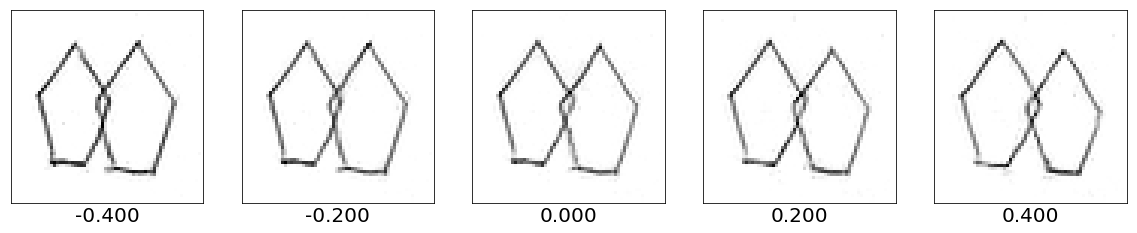

In [22]:
target_dim = 1        ### 바꾸고자 하는 latent variable index (1~50)
min_lat_value = -0.4  ### 해당 latent variable 변화 범위의 최소값
max_lat_value = 0.4   ### 해당 latent variable 변화 범위의 최대값
value_div_num = 5     ### 최대값과 최소값을 몇등분하여 볼 것인지

'''
Example))
target_dim = 1, min_lat_value = -0.4, max_lat_value = 0.5, value_div_num = 5 일 경우
첫번째 dimension의 값을 -0.4에서 0.4까지 조금씩 변화시켜가며 그림을 그린다 (나머지 dim 값은 고정).
value_div_num = 5이므로 -0.4와 0.4사이를 5등분하여 [-0.4, -0.2, 0, 0.2, 0.4] 에 대해서 그림을 그린다.

dimension에 따라서 정상 오각형에 대응되는 value범위, 변화되는 정도가 달라질 수 있으므로 
다양하게 변화시켜서 확인!
'''

z_init1 = torch.Tensor(z_init1_.copy()).to(device)
z_init2 = torch.Tensor(z_init2_.copy()).to(device)

plt.figure(figsize=(20,20))   ### 그림 plot을 위한 figure 크기 설정

z_init1[0][target_dim-1] = min_lat_value    ##해당 dimension 최소값 설정
z_init2[0][target_dim-1] = max_lat_value    ##해당 dimension 최대값 설정

dz = (z_init1-z_init2)/(value_div_num-1)    ##두개의 차이를 등분하여 value 변화량 dz를 계산
for i in range(value_div_num):
    z_change = z_init1 - (dz*i)             ##해당 dim에 dz만큼씩 더해주며 그림을 plot
    gen_img = generator(z_change).cpu()
    plt.subplot(1,value_div_num,i+1)
    plt.imshow(gen_img.data.numpy()[0][0], cmap='gray')
    
    plt.xlabel('%.3f'%z_change[0][target_dim-1], fontsize=20)
    plt.xticks([])
    plt.yticks([])
plt.show()